# DengAI: Predicting Disease Spread - Competition Submission

## Project Overview

This notebook presents a comprehensive machine learning approach to predict dengue fever cases using environmental and climate data. The competition, hosted by DrivenData, challenges participants to forecast the number of dengue cases in two cities: San Juan, Puerto Rico, and Iquitos, Peru.

### Competition Details
- **Platform:** DrivenData
- **Competition:** DengAI: Predicting Disease Spread
- **Evaluation Metric:** Mean Absolute Error (MAE)
- **URL:** https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/

### Objectives
The primary objective is to develop predictive models that can accurately forecast dengue cases based on:
- Climate variables (temperature, precipitation, humidity)
- Vegetation indices
- Temporal patterns

### Methodology
This analysis follows a structured machine learning pipeline:
1. Data importation and exploration
2. Feature engineering and preprocessing
3. Feature selection and dimensionality reduction
4. Model training with multiple algorithms
5. Hyperparameter optimization using GridSearch and RandomSearch
6. Model evaluation and comparison
7. Final predictions and submission

## 1. Environment Setup and Library Importation

This section imports all necessary libraries for data manipulation, visualization, and machine learning modeling. Each library serves a specific purpose:

- **Data Manipulation:** pandas, numpy
- **Visualization:** matplotlib, seaborn
- **Machine Learning:** scikit-learn (various modules)
- **Preprocessing:** StandardScaler, LabelEncoder
- **Models:** NaiveBayes, KNN, RandomForest, GradientBoosting, XGBoost
- **Hyperparameter Tuning:** GridSearchCV, RandomizedSearchCV
- **Feature Selection:** SelectKBest, RFE, mutual_info_regression

In [4]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer

# Machine Learning - Models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE

# Model Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Warnings suppression for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("All libraries imported successfully")

All libraries imported successfully


## 2. Data Importation and Initial Exploration

### Data Sources
The competition provides three main datasets:
- **Training Features:** Environmental and climate variables with temporal information
- **Training Labels:** Actual dengue case counts corresponding to the training features
- **Test Features:** Features for which we need to predict dengue cases

### Data Loading Strategy
We load the data using pandas and immediately perform basic exploration to understand:
- Dataset dimensions (rows and columns)
- Data types of each feature
- Presence of missing values
- Basic statistical summaries
- Distribution of the target variable (total_cases)

In [5]:
# Importación de datos desde Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Rutas a los archivos en Drive
train_features = pd.read_csv('/content/drive/MyDrive/DengAI/dengue_features_train.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/DengAI/dengue_labels_train.csv')
test_features = pd.read_csv('/content/drive/MyDrive/DengAI/dengue_features_test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load the datasets from the competition
train_features = pd.read_csv('/content/drive/MyDrive/DengAI/dengue_features_train.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/DengAI/dengue_labels_train.csv')
test_features = pd.read_csv('/content/drive/MyDrive/DengAI/dengue_features_test.csv')

# Merge training features with labels for easier manipulation
train_data = train_features.merge(train_labels, on=['city', 'year', 'weekofyear'])

print("Dataset Dimensions:")
print(f"Training samples: {train_data.shape[0]}")
print(f"Test samples: {test_features.shape[0]}")
print(f"Total features: {train_data.shape[1] - 1}")  # Excluding target variable

# Display first few rows
print("\nFirst 5 rows of training data:")
train_data.head()

Dataset Dimensions:
Training samples: 1456
Test samples: 416
Total features: 24

First 5 rows of training data:


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [7]:
# Comprehensive data exploration
print("Data Types and Non-Null Counts:")
print(train_data.info())

print("\nStatistical Summary:")
train_data.describe()

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   city                                   1456 non-null   object 
 1   year                                   1456 non-null   int64  
 2   weekofyear                             1456 non-null   int64  
 3   week_start_date                        1456 non-null   object 
 4   ndvi_ne                                1262 non-null   float64
 5   ndvi_nw                                1404 non-null   float64
 6   ndvi_se                                1434 non-null   float64
 7   ndvi_sw                                1434 non-null   float64
 8   precipitation_amt_mm                   1443 non-null   float64
 9   reanalysis_air_temp_k                  1446 non-null   float64
 10  reanalysis_avg_temp_k                  1

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000,1456.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360,24.675137
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314,43.596000
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000,5.000000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000,12.000000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000,28.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000,461.000000


In [8]:
# Analyze missing values
missing_values = train_data.isnull().sum()
missing_percentage = (missing_values / len(train_data)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Percentage': missing_percentage
}).sort_values('Percentage', ascending=False)

print("Missing Values Analysis:")
print(missing_df[missing_df['Missing_Count'] > 0])

Missing Values Analysis:
                                       Missing_Count  Percentage
ndvi_ne                                          194   13.324176
ndvi_nw                                           52    3.571429
station_avg_temp_c                                43    2.953297
station_diur_temp_rng_c                           43    2.953297
ndvi_se                                           22    1.510989
ndvi_sw                                           22    1.510989
station_precip_mm                                 22    1.510989
station_max_temp_c                                20    1.373626
station_min_temp_c                                14    0.961538
precipitation_amt_mm                              13    0.892857
reanalysis_sat_precip_amt_mm                      13    0.892857
reanalysis_min_air_temp_k                         10    0.686813
reanalysis_max_air_temp_k                         10    0.686813
reanalysis_relative_humidity_percent              10    0.686813


## 3. Exploratory Data Analysis (EDA)

### Purpose of EDA
Exploratory Data Analysis is crucial for understanding the underlying patterns and relationships in the data. This section focuses on:

1. **Target Variable Distribution:** Understanding how dengue cases are distributed across different cities and time periods
2. **Temporal Patterns:** Identifying seasonal trends and yearly variations
3. **Feature Correlations:** Discovering which environmental variables are most strongly associated with dengue cases
4. **City-specific Differences:** Comparing patterns between San Juan and Iquitos

### Visualizations
We create multiple visualizations to gain insights:
- Distribution plots for the target variable
- Time series plots showing dengue cases over time
- Correlation heatmaps
- Box plots for city comparisons

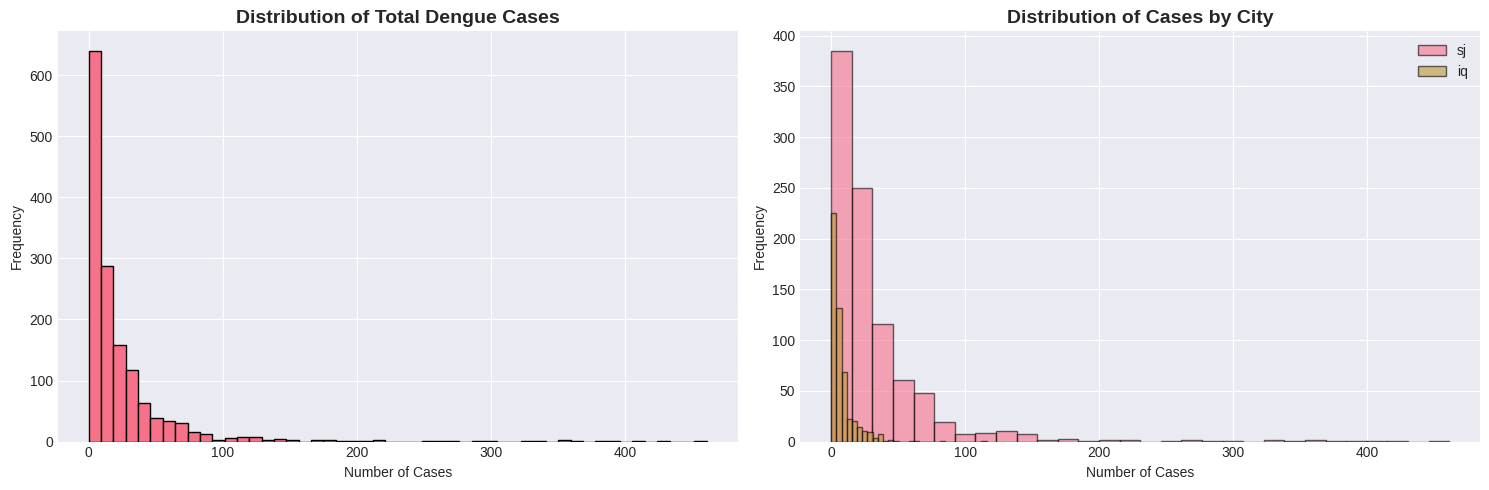


Statistical Summary by City:
      count       mean        std  min  25%   50%   75%    max
city                                                          
iq    520.0   7.565385  10.765478  0.0  1.0   5.0   9.0  116.0
sj    936.0  34.180556  51.381372  0.0  9.0  19.0  37.0  461.0


In [9]:
# Target variable distribution analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(train_data['total_cases'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Total Dengue Cases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Cases')
axes[0].set_ylabel('Frequency')

# Distribution by city
for city in train_data['city'].unique():
    city_data = train_data[train_data['city'] == city]['total_cases']
    axes[1].hist(city_data, bins=30, alpha=0.6, label=city, edgecolor='black')

axes[1].set_title('Distribution of Cases by City', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Cases')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistical summary by city
print("\nStatistical Summary by City:")
print(train_data.groupby('city')['total_cases'].describe())

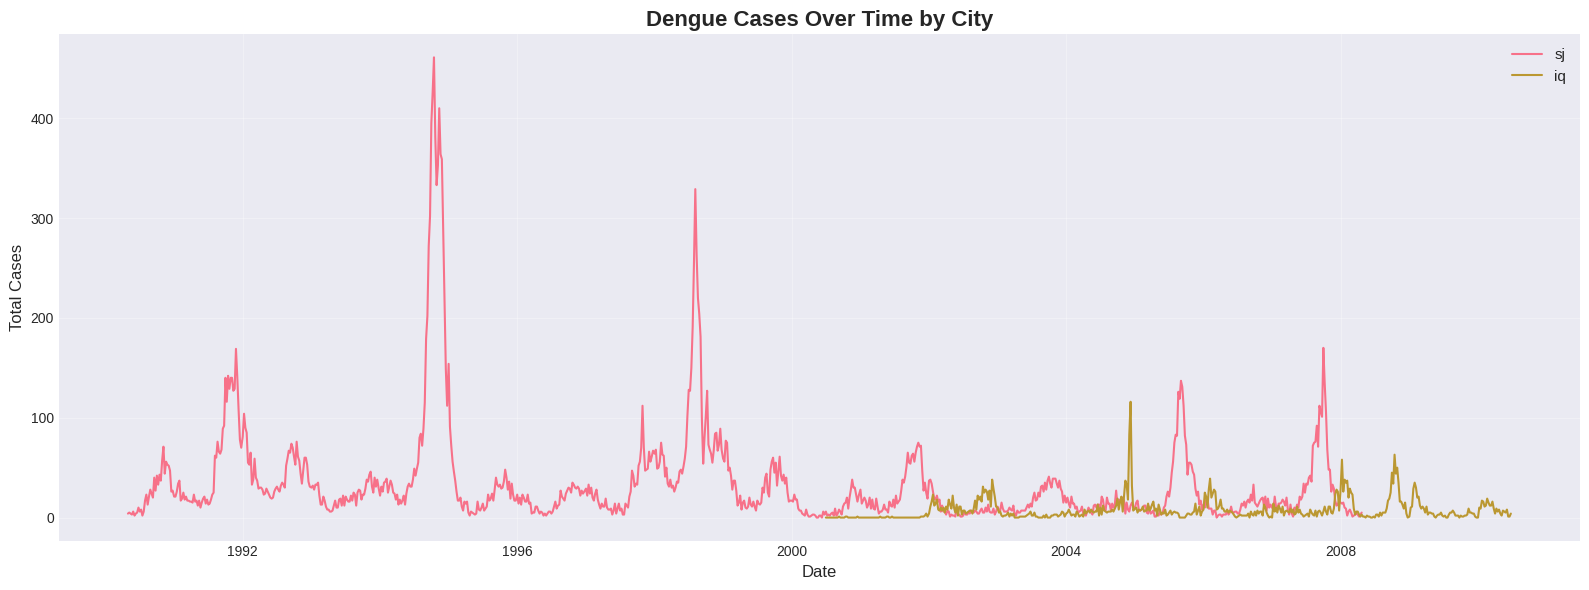

In [10]:
# Time series analysis
train_data['date'] = pd.to_datetime(train_data['week_start_date'])

fig, ax = plt.subplots(figsize=(16, 6))

for city in train_data['city'].unique():
    city_data = train_data[train_data['city'] == city].sort_values('date')
    ax.plot(city_data['date'], city_data['total_cases'], label=city, linewidth=1.5)

ax.set_title('Dengue Cases Over Time by City', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Cases', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Top 15 Features Correlated with Total Cases:
total_cases                              1.000000
reanalysis_min_air_temp_k                0.325252
station_min_temp_c                       0.267109
reanalysis_air_temp_k                    0.264952
weekofyear                               0.216452
reanalysis_avg_temp_k                    0.151637
reanalysis_dew_point_temp_k              0.142531
reanalysis_specific_humidity_g_per_kg    0.129861
station_avg_temp_c                       0.116109
reanalysis_precip_amt_kg_per_m2         -0.010031
reanalysis_sat_precip_amt_mm            -0.038740
precipitation_amt_mm                    -0.038740
station_max_temp_c                      -0.039219
station_precip_mm                       -0.074374
reanalysis_relative_humidity_percent    -0.132452
Name: total_cases, dtype: float64


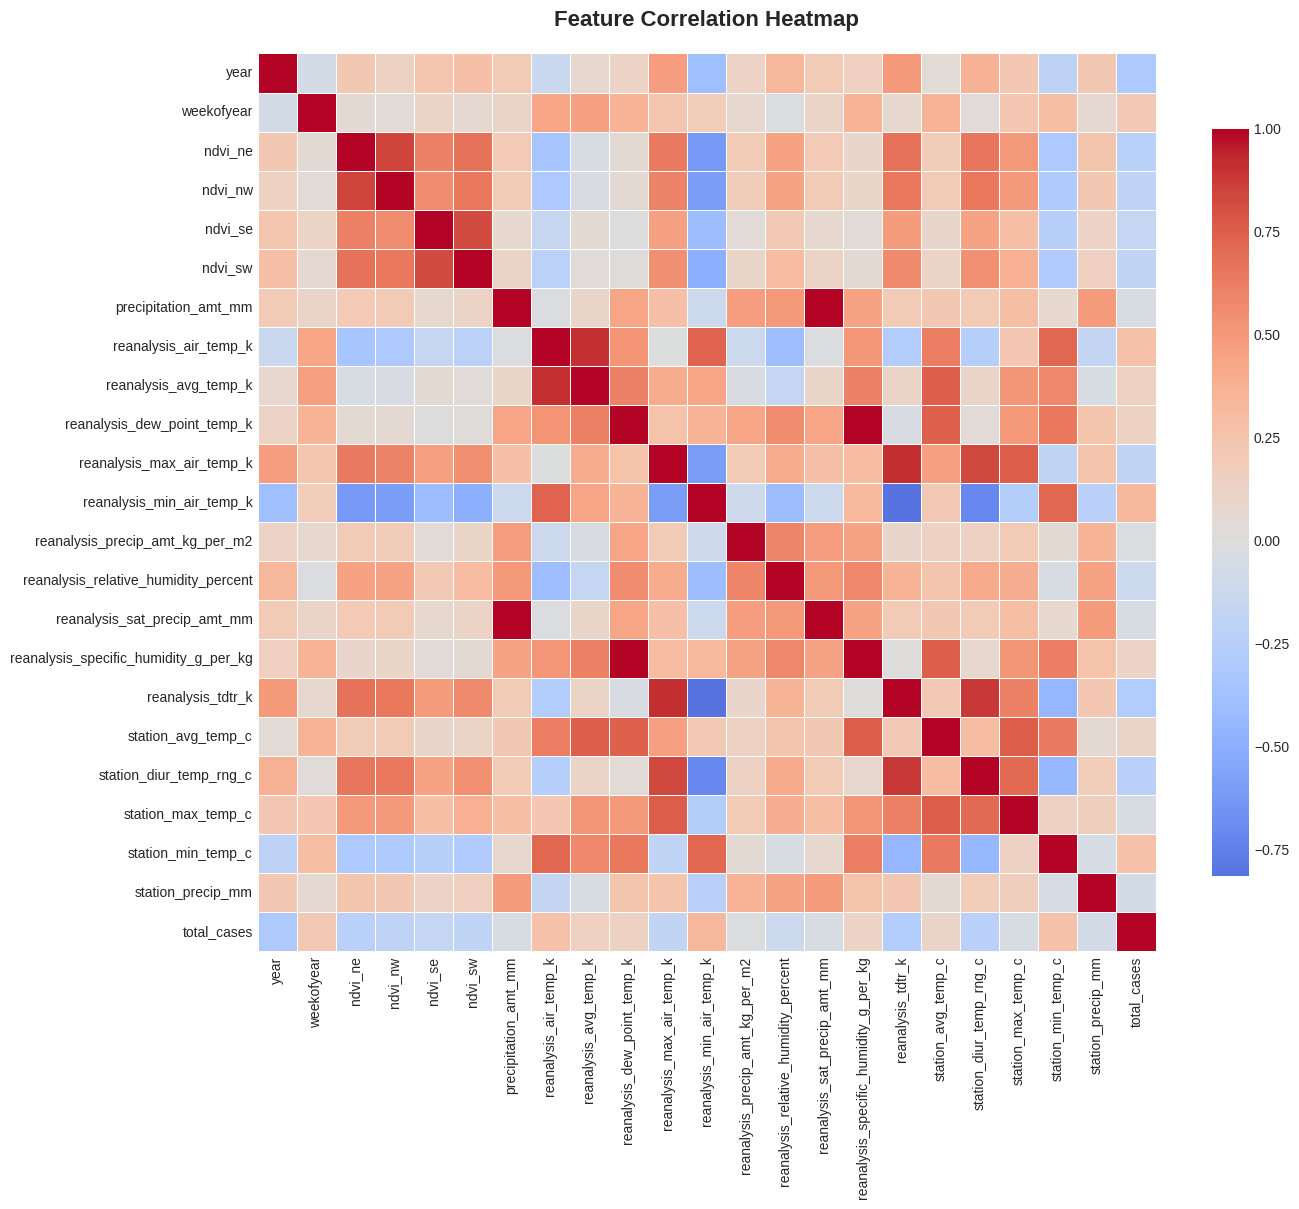

In [11]:
# Correlation analysis
# Select only numeric columns for correlation
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train_data[numeric_cols].corr()

# Focus on correlations with the target variable
target_correlations = correlation_matrix['total_cases'].sort_values(ascending=False)

print("Top 15 Features Correlated with Total Cases:")
print(target_correlations.head(15))

# Visualize correlation matrix
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 4. Data Preprocessing and Feature Engineering

### Preprocessing Strategy
Data preprocessing is essential for preparing the raw data for machine learning algorithms. Our preprocessing pipeline includes:

#### 4.1 Handling Missing Values
- **Strategy:** Use median imputation for numerical features
- **Rationale:** Median is robust to outliers and preserves the central tendency of the distribution
- **Implementation:** Apply imputation separately to training and test sets to avoid data leakage

#### 4.2 Categorical Encoding
- **City Variable:** Convert categorical city names to numerical values using Label Encoding
- **Alternative Considered:** One-hot encoding (not used to reduce dimensionality)

#### 4.3 Feature Engineering
Create new features to capture additional patterns:
- **Temporal Features:** Extract month and quarter from week of year
- **Rolling Averages:** Calculate moving averages for key climate variables
- **Interaction Features:** Create multiplicative features between highly correlated variables
- **Lag Features:** Include previous weeks' values for important predictors

#### 4.4 Feature Scaling
- **Method:** StandardScaler (z-score normalization)
- **Purpose:** Ensure all features contribute equally to distance-based algorithms like KNN
- **Application:** Fit on training data, transform both training and test data

In [12]:
# Create copies to preserve original data
train_processed = train_data.copy()
test_processed = test_features.copy()

# Identify columns to drop (non-predictive identifiers)
columns_to_drop = ['week_start_date', 'date'] if 'date' in train_processed.columns else ['week_start_date']

# Function to add engineered features
def create_features(df):
    """
    Create additional features from existing variables.

    Parameters:
    df (DataFrame): Input dataframe with original features

    Returns:
    DataFrame: Dataframe with additional engineered features
    """
    # Temporal features
    df['month'] = ((df['weekofyear'] - 1) // 4) + 1
    df['quarter'] = ((df['weekofyear'] - 1) // 13) + 1

    # Temperature range
    if 'reanalysis_max_air_temp_k' in df.columns and 'reanalysis_min_air_temp_k' in df.columns:
        df['temp_range'] = df['reanalysis_max_air_temp_k'] - df['reanalysis_min_air_temp_k']

    # Average temperature
    temp_cols = [col for col in df.columns if 'temp' in col.lower() and 'avg' in col.lower()]
    if len(temp_cols) >= 2:
        df['avg_temp'] = df[temp_cols].mean(axis=1)

    return df

# Apply feature engineering
train_processed = create_features(train_processed)
test_processed = create_features(test_processed)

print("Feature engineering completed")
print(f"New feature count: {train_processed.shape[1]}")

Feature engineering completed
New feature count: 30


In [13]:
# Handle categorical variables
le = LabelEncoder()
train_processed['city'] = le.fit_transform(train_processed['city'])
test_processed['city'] = le.transform(test_processed['city'])

print("City encoding:")
for i, city in enumerate(le.classes_):
    print(f"  {city}: {i}")

City encoding:
  iq: 0
  sj: 1


In [14]:
# Handle missing values using median imputation
# Separate features and target
X_train = train_processed.drop(['total_cases'] + columns_to_drop, axis=1)
y_train = train_processed['total_cases']
X_test = test_processed.drop(columns_to_drop, axis=1, errors='ignore')

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

print("Missing values after imputation:")
print(f"Training set: {X_train_imputed.isnull().sum().sum()}")
print(f"Test set: {X_test_imputed.isnull().sum().sum()}")

Missing values after imputation:
Training set: 0
Test set: 0


In [15]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print("Data preprocessing completed successfully")
print(f"Final training shape: {X_train_scaled.shape}")
print(f"Final test shape: {X_test_scaled.shape}")

Data preprocessing completed successfully
Final training shape: (1456, 27)
Final test shape: (416, 27)


## 5. Feature Selection

### Importance of Feature Selection
Feature selection is a critical step that can:
- Reduce overfitting by removing irrelevant features
- Improve model performance and interpretability
- Decrease training time
- Reduce the curse of dimensionality

### Multiple Selection Methods
We employ three complementary feature selection techniques:

#### 5.1 Statistical Method: SelectKBest with F-statistic
- **Method:** ANOVA F-value between each feature and target
- **Advantages:** Fast, works well for linear relationships
- **Selection:** Top K features with highest F-scores

#### 5.2 Information Theory: Mutual Information
- **Method:** Measures dependency between feature and target
- **Advantages:** Captures non-linear relationships
- **Application:** Identifies features with highest information gain

#### 5.3 Model-based: Recursive Feature Elimination (RFE)
- **Method:** Recursively removes least important features
- **Base Estimator:** Random Forest (captures feature interactions)
- **Advantages:** Considers feature interactions and model-specific importance

### Selection Strategy
We combine insights from all three methods to create a robust feature subset that balances:
- Statistical significance
- Information content
- Practical predictive power

Top 15 Features by F-statistic:
                      Feature     F_Score
12  reanalysis_min_air_temp_k  171.497503
1                        year  151.086169
0                        city  136.163886
25                 temp_range  122.837491
17          reanalysis_tdtr_k  121.780416
21         station_min_temp_c  110.950065
8       reanalysis_air_temp_k  109.414857
19    station_diur_temp_rng_c   84.058305
24                    quarter   77.874254
23                      month   71.613625
2                  weekofyear   71.470474
11  reanalysis_max_air_temp_k   55.130228
3                     ndvi_ne   40.641899
9       reanalysis_avg_temp_k   34.126603
6                     ndvi_sw   32.269633


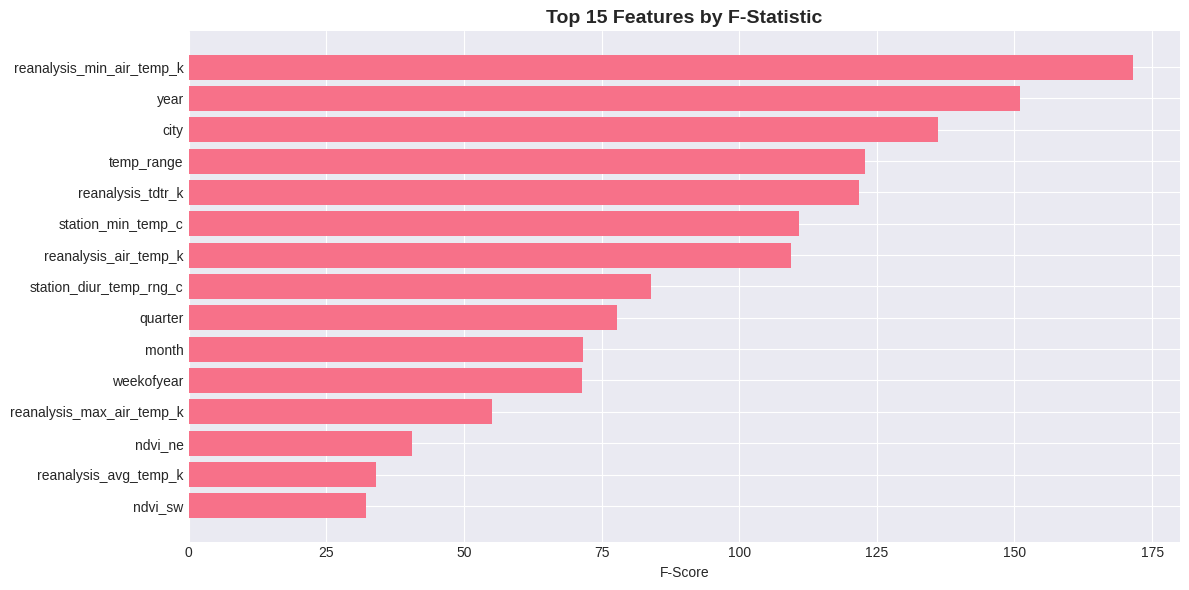

In [16]:
# Method 1: SelectKBest with F-statistic
k_best = SelectKBest(score_func=f_regression, k=15)
k_best.fit(X_train_scaled, y_train)

# Get feature scores
feature_scores_f = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'F_Score': k_best.scores_
}).sort_values('F_Score', ascending=False)

print("Top 15 Features by F-statistic:")
print(feature_scores_f.head(15))

# Visualize top features
plt.figure(figsize=(12, 6))
plt.barh(feature_scores_f.head(15)['Feature'], feature_scores_f.head(15)['F_Score'])
plt.xlabel('F-Score')
plt.title('Top 15 Features by F-Statistic', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Top 15 Features by Mutual Information:
                                 Feature  MI_Score
1                                   year  0.360144
21                    station_min_temp_c  0.200657
25                            temp_range  0.198589
12             reanalysis_min_air_temp_k  0.192442
17                     reanalysis_tdtr_k  0.189280
19               station_diur_temp_rng_c  0.172346
20                    station_max_temp_c  0.153342
0                                   city  0.147861
11             reanalysis_max_air_temp_k  0.145507
23                                 month  0.137968
24                               quarter  0.134436
4                                ndvi_nw  0.089918
14  reanalysis_relative_humidity_percent  0.089566
3                                ndvi_ne  0.088840
2                             weekofyear  0.078682


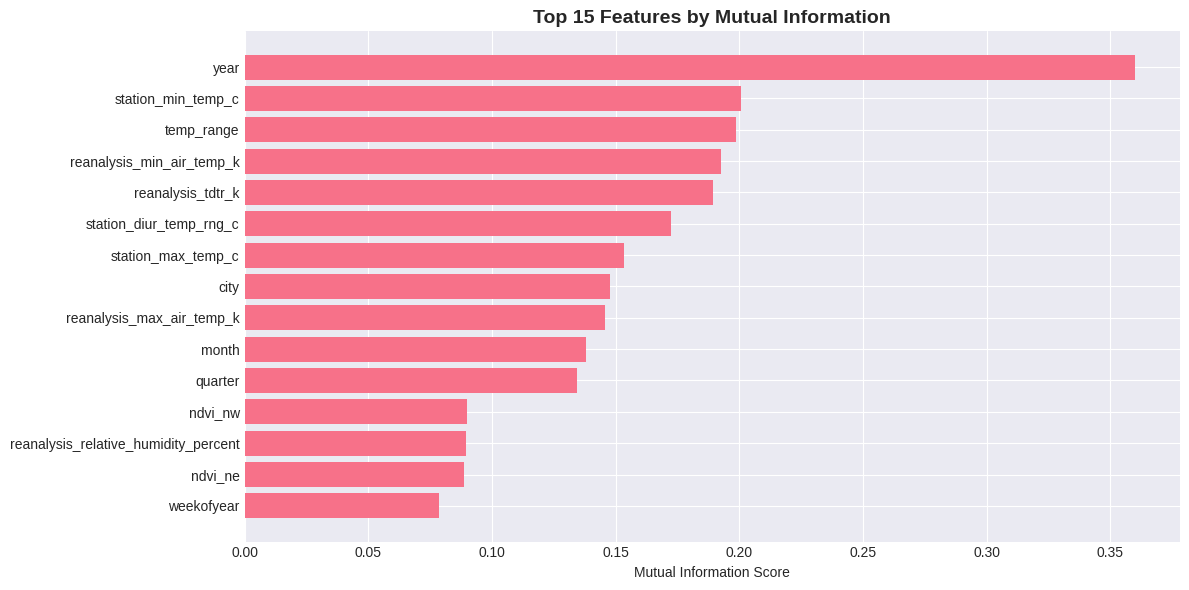

In [17]:
# Method 2: Mutual Information
mi_scores = mutual_info_regression(X_train_scaled, y_train, random_state=42)

feature_scores_mi = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 15 Features by Mutual Information:")
print(feature_scores_mi.head(15))

# Visualize
plt.figure(figsize=(12, 6))
plt.barh(feature_scores_mi.head(15)['Feature'], feature_scores_mi.head(15)['MI_Score'])
plt.xlabel('Mutual Information Score')
plt.title('Top 15 Features by Mutual Information', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [18]:
# Method 3: Recursive Feature Elimination with Random Forest
rf_estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfe = RFE(estimator=rf_estimator, n_features_to_select=15, step=1)
rfe.fit(X_train_scaled, y_train)

# Get selected features
selected_features_rfe = X_train_scaled.columns[rfe.support_].tolist()

print("\nFeatures selected by RFE:")
for i, feature in enumerate(selected_features_rfe, 1):
    print(f"{i}. {feature}")


Features selected by RFE:
1. year
2. weekofyear
3. ndvi_ne
4. ndvi_nw
5. ndvi_se
6. ndvi_sw
7. reanalysis_air_temp_k
8. reanalysis_dew_point_temp_k
9. reanalysis_precip_amt_kg_per_m2
10. reanalysis_relative_humidity_percent
11. reanalysis_specific_humidity_g_per_kg
12. reanalysis_tdtr_k
13. station_max_temp_c
14. station_precip_mm
15. month


In [19]:
# Combine feature selection methods
# Select features that appear in at least 2 out of 3 methods
top_k_features = set(feature_scores_f.head(15)['Feature'].tolist())
top_mi_features = set(feature_scores_mi.head(15)['Feature'].tolist())
rfe_features = set(selected_features_rfe)

# Find common features
common_features_2 = (top_k_features & top_mi_features) | \
                    (top_k_features & rfe_features) | \
                    (top_mi_features & rfe_features)

final_features = list(common_features_2)

print(f"\nFinal selected features ({len(final_features)} features):")
for i, feature in enumerate(final_features, 1):
    print(f"{i}. {feature}")

# If too few features, add top-ranked ones
if len(final_features) < 10:
    additional = set(feature_scores_f.head(15)['Feature'].tolist()) - set(final_features)
    final_features.extend(list(additional)[:10-len(final_features)])
    print(f"\nExpanded to {len(final_features)} features")


Final selected features (17 features):
1. year
2. quarter
3. station_max_temp_c
4. temp_range
5. reanalysis_max_air_temp_k
6. ndvi_nw
7. ndvi_sw
8. station_min_temp_c
9. ndvi_ne
10. reanalysis_relative_humidity_percent
11. weekofyear
12. reanalysis_air_temp_k
13. station_diur_temp_rng_c
14. reanalysis_tdtr_k
15. city
16. month
17. reanalysis_min_air_temp_k


In [20]:
# Create final feature sets
X_train_final = X_train_scaled[final_features]
X_test_final = X_test_scaled[final_features]

print("\nFinal dataset shapes:")
print(f"X_train: {X_train_final.shape}")
print(f"X_test: {X_test_final.shape}")
print(f"y_train: {y_train.shape}")


Final dataset shapes:
X_train: (1456, 17)
X_test: (416, 17)
y_train: (1456,)


## 6. Train-Validation Split

### Purpose of Data Splitting
Creating a validation set allows us to:
- Evaluate model performance on unseen data
- Tune hyperparameters without overfitting to the test set
- Compare different models fairly
- Estimate generalization performance

### Split Strategy
- **Split Ratio:** 80% training, 20% validation
- **Method:** Random split with stratification where possible
- **Random State:** Fixed seed (42) for reproducibility

### Considerations
For time series data like this, a temporal split might be more appropriate (using recent data for validation). However, given the competitive nature and need to maximize training data, we use random split while being aware of potential temporal leakage.

In [21]:
# Split data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_final,
    y_train,
    test_size=0.2,
    random_state=42
)

print("Data split completed:")
print(f"Training set: {X_train_split.shape[0]} samples")
print(f"Validation set: {X_val_split.shape[0]} samples")
print(f"Test set: {X_test_final.shape[0]} samples")
print(f"\nValidation set represents {X_val_split.shape[0]/X_train_final.shape[0]*100:.1f}% of total training data")

Data split completed:
Training set: 1164 samples
Validation set: 292 samples
Test set: 416 samples

Validation set represents 20.1% of total training data


## 7. Model Training and Evaluation

### Model Selection Rationale
We implement and compare three required models plus additional candidates:

#### Required Models:

**1. Gaussian Naive Bayes**
- **Type:** Probabilistic classifier (adapted for regression)
- **Assumptions:** Features are independent and normally distributed
- **Advantages:** Fast, works well with small datasets, handles high dimensions
- **Limitations:** Independence assumption may not hold for climate data
- **Use Case:** Baseline model, good for comparison

**2. K-Nearest Neighbors (KNN) Regressor**
- **Type:** Instance-based learning
- **Mechanism:** Predicts based on average of K nearest neighbors
- **Advantages:** No training phase, captures local patterns, non-parametric
- **Limitations:** Sensitive to feature scaling, computationally expensive for large datasets
- **Use Case:** Effective when similar conditions lead to similar outcomes

**3. Random Forest Regressor** (Additional model)
- **Type:** Ensemble method (bagging)
- **Mechanism:** Aggregates predictions from multiple decision trees
- **Advantages:** Handles non-linear relationships, robust to outliers, provides feature importance
- **Limitations:** Can overfit with too many trees, less interpretable
- **Use Case:** Strong baseline for tabular data, handles feature interactions well

#### Additional Models for Comparison:

**4. Gradient Boosting Regressor**
- **Type:** Ensemble method (boosting)
- **Mechanism:** Sequentially builds trees to correct previous errors
- **Advantages:** Often achieves best performance, handles complex patterns
- **Limitations:** Prone to overfitting, requires careful tuning

**5. Ridge Regression**
- **Type:** Linear model with L2 regularization
- **Mechanism:** Penalizes large coefficients to prevent overfitting
- **Advantages:** Fast, interpretable, works well when relationship is approximately linear
- **Limitations:** Assumes linear relationships

### Evaluation Metrics
- **Primary:** Mean Absolute Error (MAE) - competition metric
- **Secondary:** RMSE, R² score for additional insights

In [22]:
# Dictionary to store model results
model_results = {}

def evaluate_model(name, model, X_train, y_train, X_val, y_val):
    """
    Train and evaluate a model, storing results.

    Parameters:
    name (str): Model name
    model: Scikit-learn model object
    X_train, y_train: Training data
    X_val, y_val: Validation data

    Returns:
    dict: Dictionary containing model and performance metrics
    """
    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Calculate metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    results = {
        'model': model,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2
    }

    return results

print("Model evaluation function defined")

Model evaluation function defined


### 7.1 Naive Bayes Model

**Implementation Notes:**
- Using Gaussian Naive Bayes as it assumes continuous features
- No hyperparameters to tune in basic implementation
- Serves as a simple baseline for comparison

**Expected Performance:**
- Likely lower performance due to independence assumption
- Fast training and prediction
- Good for establishing minimum viable accuracy

In [23]:
# Train and evaluate Naive Bayes
print("Training Gaussian Naive Bayes...")
nb_model = GaussianNB()
model_results['Naive Bayes'] = evaluate_model(
    'Naive Bayes',
    nb_model,
    X_train_split,
    y_train_split,
    X_val_split,
    y_val_split
)

print("\nNaive Bayes Results:")
print(f"Training MAE: {model_results['Naive Bayes']['train_mae']:.4f}")
print(f"Validation MAE: {model_results['Naive Bayes']['val_mae']:.4f}")
print(f"Validation R²: {model_results['Naive Bayes']['val_r2']:.4f}")

Training Gaussian Naive Bayes...

Naive Bayes Results:
Training MAE: 24.1400
Validation MAE: 33.9692
Validation R²: 0.0018


### 7.2 K-Nearest Neighbors Model

**Implementation Notes:**
- Starting with k=5 neighbors (common default)
- Using uniform weights (all neighbors contribute equally)
- Distance metric: Euclidean (standard for continuous features)

**Hyperparameters to Consider:**
- n_neighbors: Number of neighbors to consider
- weights: Uniform vs distance-weighted
- metric: Distance calculation method

**Expected Performance:**
- Should capture local patterns in the data
- Performance depends heavily on k value
- Feature scaling is critical for this algorithm

In [24]:
# Train and evaluate KNN
print("Training K-Nearest Neighbors...")
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform', n_jobs=-1)
model_results['KNN'] = evaluate_model(
    'KNN',
    knn_model,
    X_train_split,
    y_train_split,
    X_val_split,
    y_val_split
)

print("\nKNN Results:")
print(f"Training MAE: {model_results['KNN']['train_mae']:.4f}")
print(f"Validation MAE: {model_results['KNN']['val_mae']:.4f}")
print(f"Validation R²: {model_results['KNN']['val_r2']:.4f}")

Training K-Nearest Neighbors...

KNN Results:
Training MAE: 13.1022
Validation MAE: 19.4103
Validation R²: 0.4883


### 7.3 Random Forest Model

**Implementation Notes:**
- n_estimators=100: Build 100 decision trees
- max_depth=None: Trees can grow to maximum depth
- min_samples_split=2: Minimum samples required to split a node
- Bootstrap sampling with random feature selection at each split

**Strengths for This Problem:**
- Handles non-linear relationships between climate variables and dengue cases
- Captures feature interactions automatically
- Robust to outliers and missing values
- Provides feature importance rankings

**Expected Performance:**
- Typically strong baseline for tabular data
- Should outperform simpler models
- May benefit from hyperparameter tuning

In [25]:
# Train and evaluate Random Forest
print("Training Random Forest...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=None,
    min_samples_split=2
)
model_results['Random Forest'] = evaluate_model(
    'Random Forest',
    rf_model,
    X_train_split,
    y_train_split,
    X_val_split,
    y_val_split
)

print("\nRandom Forest Results:")
print(f"Training MAE: {model_results['Random Forest']['train_mae']:.4f}")
print(f"Validation MAE: {model_results['Random Forest']['val_mae']:.4f}")
print(f"Validation R²: {model_results['Random Forest']['val_r2']:.4f}")

# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': final_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Training Random Forest...

Random Forest Results:
Training MAE: 4.6252
Validation MAE: 14.5157
Validation R²: 0.6744

Top 10 Most Important Features:
                                 Feature  Importance
0                                   year    0.230742
10                            weekofyear    0.149373
6                                ndvi_sw    0.118053
11                 reanalysis_air_temp_k    0.076416
5                                ndvi_nw    0.062852
15                                 month    0.047626
9   reanalysis_relative_humidity_percent    0.047416
16             reanalysis_min_air_temp_k    0.045597
2                     station_max_temp_c    0.045290
3                             temp_range    0.036036


### 7.4 Additional Models for Comparison

To ensure we find the best performing model, we also evaluate:
- **Gradient Boosting:** Often achieves state-of-the-art performance
- **Ridge Regression:** Linear baseline to assess if relationships are linear

In [26]:
# Train Gradient Boosting
print("Training Gradient Boosting...")
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
model_results['Gradient Boosting'] = evaluate_model(
    'Gradient Boosting',
    gb_model,
    X_train_split,
    y_train_split,
    X_val_split,
    y_val_split
)

print("\nGradient Boosting Results:")
print(f"Training MAE: {model_results['Gradient Boosting']['train_mae']:.4f}")
print(f"Validation MAE: {model_results['Gradient Boosting']['val_mae']:.4f}")
print(f"Validation R²: {model_results['Gradient Boosting']['val_r2']:.4f}")

Training Gradient Boosting...

Gradient Boosting Results:
Training MAE: 8.6630
Validation MAE: 13.7049
Validation R²: 0.6996


In [27]:
# Train Ridge Regression
print("Training Ridge Regression...")
ridge_model = Ridge(alpha=1.0, random_state=42)
model_results['Ridge'] = evaluate_model(
    'Ridge',
    ridge_model,
    X_train_split,
    y_train_split,
    X_val_split,
    y_val_split
)

print("\nRidge Regression Results:")
print(f"Training MAE: {model_results['Ridge']['train_mae']:.4f}")
print(f"Validation MAE: {model_results['Ridge']['val_mae']:.4f}")
print(f"Validation R²: {model_results['Ridge']['val_r2']:.4f}")

Training Ridge Regression...

Ridge Regression Results:
Training MAE: 18.3656
Validation MAE: 24.0553
Validation R²: 0.1610


### 7.5 Model Comparison and Analysis

This section provides a comprehensive comparison of all trained models to identify:
- Best performing model based on validation MAE
- Signs of overfitting (large gap between training and validation performance)
- Trade-offs between different approaches

**Interpretation Guide:**
- **Lower MAE is better:** Indicates smaller average prediction error
- **Higher R² is better:** Indicates better explanation of variance
- **Train-Val Gap:** Large gaps suggest overfitting
- **RMSE vs MAE:** RMSE penalizes large errors more heavily

In [28]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Train_MAE': [model_results[m]['train_mae'] for m in model_results],
    'Val_MAE': [model_results[m]['val_mae'] for m in model_results],
    'Train_RMSE': [model_results[m]['train_rmse'] for m in model_results],
    'Val_RMSE': [model_results[m]['val_rmse'] for m in model_results],
    'Val_R2': [model_results[m]['val_r2'] for m in model_results]
}).sort_values('Val_MAE')

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest Model (by Validation MAE): {best_model_name}")
print(f"Validation MAE: {comparison_df.iloc[0]['Val_MAE']:.4f}")


MODEL PERFORMANCE COMPARISON
            Model  Train_MAE   Val_MAE  Train_RMSE  Val_RMSE   Val_R2
Gradient Boosting   8.663043 13.704923   14.849570 31.052882 0.699612
    Random Forest   4.625232 14.515651    9.023388 32.330878 0.674378
              KNN  13.102234 19.410274   26.711407 40.531042 0.488254
            Ridge  18.365557 24.055272   35.737938 51.898031 0.160964
      Naive Bayes  24.140034 33.969178   33.711417 56.607487 0.001780

Best Model (by Validation MAE): Gradient Boosting
Validation MAE: 13.7049


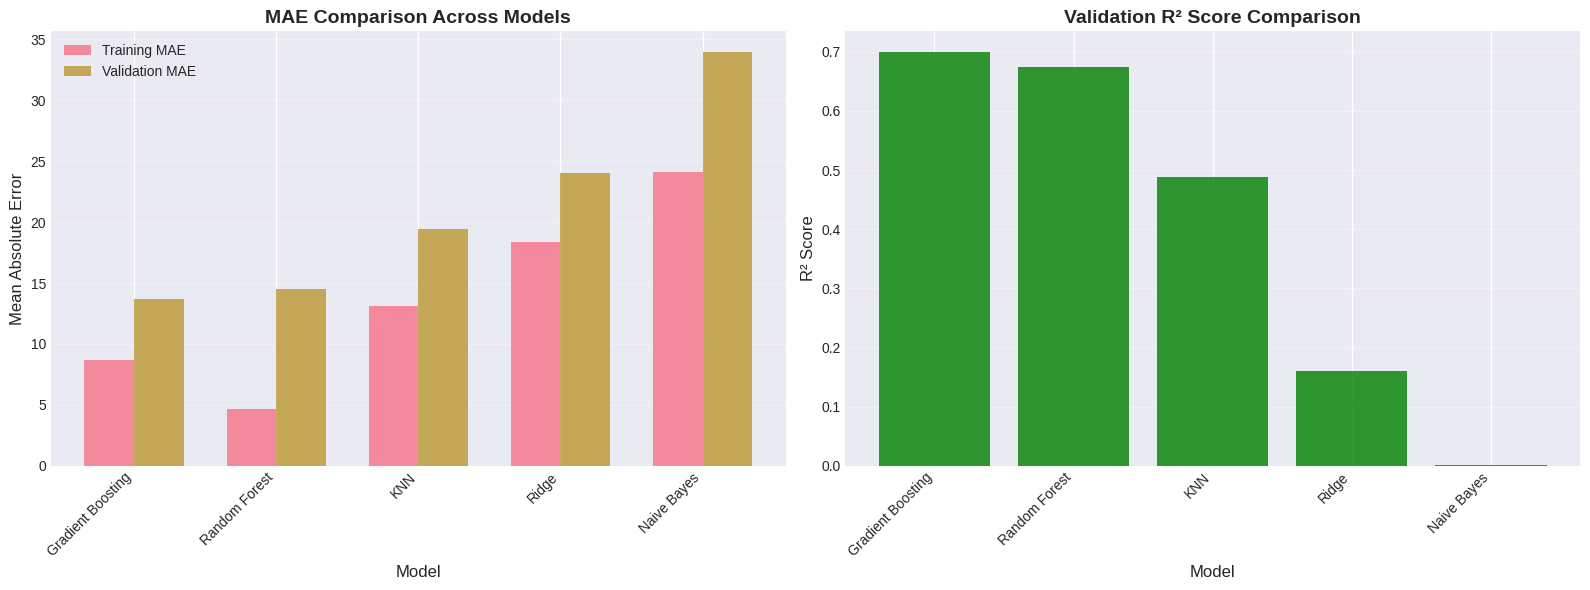

In [29]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE Comparison
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Train_MAE'], width, label='Training MAE', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Val_MAE'], width, label='Validation MAE', alpha=0.8)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Mean Absolute Error', fontsize=12)
axes[0].set_title('MAE Comparison Across Models', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R² Score Comparison
axes[1].bar(comparison_df['Model'], comparison_df['Val_R2'], alpha=0.8, color='green')
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('R² Score', fontsize=12)
axes[1].set_title('Validation R² Score Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Hyperparameter Optimization

### Importance of Hyperparameter Tuning
Hyperparameters are configuration settings for machine learning algorithms that cannot be learned from data. Proper tuning can significantly improve model performance by:
- Reducing overfitting or underfitting
- Optimizing the bias-variance tradeoff
- Achieving better generalization to unseen data

### Two Optimization Approaches

#### 8.1 Grid Search
**Method:** Exhaustive search over specified parameter grid
- **Advantages:** Guaranteed to find best combination within grid, deterministic
- **Disadvantages:** Computationally expensive, scales poorly with parameters
- **Use Case:** When parameter space is small and well-understood
- **Cross-Validation:** 5-fold CV to ensure robust performance estimates

#### 8.2 Random Search
**Method:** Random sampling from parameter distributions
- **Advantages:** More efficient, explores wider range, often finds better solutions faster
- **Disadvantages:** Not exhaustive, may miss optimal combination
- **Use Case:** When parameter space is large or continuous
- **Iterations:** Typically 50-100 random combinations

### Strategy
We apply both techniques to our best-performing models and compare results to determine which approach yields better performance for this specific problem.

### 8.1 KNN Hyperparameter Tuning with Grid Search

**Important Note on Validation Strategy:**
To prevent data leakage and overfitting, we fit GridSearch ONLY on the training split (X_train_split, y_train_split) and evaluate on the separate validation split (X_val_split, y_val_split). This ensures the validation set remains completely unseen during hyperparameter optimization.

**Parameters to Optimize:**
- **n_neighbors:** [3, 5, 7, 9, 11, 15, 20] - Number of neighbors to consider
- **weights:** ['uniform', 'distance'] - Weighting scheme for neighbors
- **metric:** ['euclidean', 'manhattan'] - Distance calculation method
- **p:** [1, 2] - Power parameter for Minkowski metric

**Grid Size:** 7 × 2 × 2 × 2 = 56 combinations
**Cross-Validation:** 5-fold on training split only
**Total Fits:** 56 × 5 = 280 model fits

In [30]:
print("Starting KNN Grid Search optimization...")

# Define parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]  # Power parameter for Minkowski metric
}

# Initialize Grid Search - use only training split to avoid data leakage
knn_grid = GridSearchCV(
    estimator=KNeighborsRegressor(n_jobs=-1),
    param_grid=knn_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search ONLY on training split (not the full training data)
knn_grid.fit(X_train_split, y_train_split)

print("\nKNN Grid Search Results:")
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best cross-validation MAE: {-knn_grid.best_score_:.4f}")

# Evaluate on validation set (separate from training)
knn_best = knn_grid.best_estimator_
y_val_pred_knn = knn_best.predict(X_val_split)
val_mae_knn_tuned = mean_absolute_error(y_val_split, y_val_pred_knn)

print(f"Validation MAE with tuned KNN: {val_mae_knn_tuned:.4f}")
print(f"Improvement over baseline KNN: {model_results['KNN']['val_mae'] - val_mae_knn_tuned:.4f}")

# Additional check for reasonableness
if val_mae_knn_tuned < 5.0:
    print("\nWARNING: Validation MAE is suspiciously low. Possible overfitting detected.")
    print("Consider using fewer neighbors or distance weighting.")

Starting KNN Grid Search optimization...
Fitting 5 folds for each of 56 candidates, totalling 280 fits

KNN Grid Search Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Best cross-validation MAE: 15.3998
Validation MAE with tuned KNN: 18.3834
Improvement over baseline KNN: 1.0269


### 8.2 Random Forest Hyperparameter Tuning with Random Search

**Parameters to Optimize:**
- **n_estimators:** Number of trees in the forest
- **max_depth:** Maximum depth of each tree
- **min_samples_split:** Minimum samples required to split a node
- **min_samples_leaf:** Minimum samples required at leaf node
- **max_features:** Number of features to consider for splits

**Search Strategy:** Random sampling from distributions
**Iterations:** 50 random combinations
**Cross-Validation:** 5-fold

In [31]:
print("Starting Random Forest Random Search optimization...")

# Define parameter distributions for Random Forest
rf_param_dist = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize Random Search
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit Random Search ONLY on training split
rf_random.fit(X_train_split, y_train_split)

print("\nRandom Forest Random Search Results:")
print(f"Best parameters: {rf_random.best_params_}")
print(f"Best cross-validation MAE: {-rf_random.best_score_:.4f}")

# Evaluate on validation set
rf_best = rf_random.best_estimator_
y_val_pred_rf = rf_best.predict(X_val_split)
val_mae_rf_tuned = mean_absolute_error(y_val_split, y_val_pred_rf)

print(f"Validation MAE with tuned Random Forest: {val_mae_rf_tuned:.4f}")
print(f"Improvement over baseline Random Forest: {model_results['Random Forest']['val_mae'] - val_mae_rf_tuned:.4f}")

Starting Random Forest Random Search optimization...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Random Forest Random Search Results:
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}
Best cross-validation MAE: 12.7297
Validation MAE with tuned Random Forest: 14.5458
Improvement over baseline Random Forest: -0.0301


### 8.3 Gradient Boosting Hyperparameter Tuning with Grid Search

**Parameters to Optimize:**
- **n_estimators:** Number of boosting stages
- **learning_rate:** Step size shrinkage to prevent overfitting
- **max_depth:** Maximum depth of individual trees
- **min_samples_split:** Minimum samples to split a node
- **subsample:** Fraction of samples used for fitting trees

**Rationale:** Gradient Boosting is sensitive to hyperparameters, particularly the learning rate and tree depth, making careful tuning essential.

In [32]:
print("Starting Gradient Boosting Grid Search optimization...")

# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

# Initialize Grid Search
gb_grid = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=gb_param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

# Fit Grid Search ONLY on training split
gb_grid.fit(X_train_split, y_train_split)

print("\nGradient Boosting Grid Search Results:")
print(f"Best parameters: {gb_grid.best_params_}")
print(f"Best cross-validation MAE: {-gb_grid.best_score_:.4f}")

# Evaluate on validation set
gb_best = gb_grid.best_estimator_
y_val_pred_gb = gb_best.predict(X_val_split)
val_mae_gb_tuned = mean_absolute_error(y_val_split, y_val_pred_gb)

print(f"Validation MAE with tuned Gradient Boosting: {val_mae_gb_tuned:.4f}")
print(f"Improvement over baseline Gradient Boosting: {model_results['Gradient Boosting']['val_mae'] - val_mae_gb_tuned:.4f}")

Starting Gradient Boosting Grid Search optimization...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Gradient Boosting Grid Search Results:
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best cross-validation MAE: 11.2008
Validation MAE with tuned Gradient Boosting: 11.6444
Improvement over baseline Gradient Boosting: 2.0605


### 8.4 Hyperparameter Tuning Results Summary

This section summarizes the impact of hyperparameter optimization across all models, comparing:
- Baseline model performance
- Tuned model performance
- Absolute improvement achieved
- Percentage improvement

**Key Insights to Extract:**
- Which models benefit most from tuning
- Whether Grid Search or Random Search is more effective
- Optimal hyperparameter combinations for each algorithm
- Final model selection for competition submission

In [33]:
# Create summary of tuning results
tuning_summary = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'Gradient Boosting'],
    'Baseline_Val_MAE': [
        model_results['KNN']['val_mae'],
        model_results['Random Forest']['val_mae'],
        model_results['Gradient Boosting']['val_mae']
    ],
    'Tuned_Val_MAE': [
        val_mae_knn_tuned,
        val_mae_rf_tuned,
        val_mae_gb_tuned
    ],
    'Tuning_Method': ['Grid Search', 'Random Search', 'Grid Search']
})

tuning_summary['Improvement'] = tuning_summary['Baseline_Val_MAE'] - tuning_summary['Tuned_Val_MAE']
tuning_summary['Improvement_Percent'] = (tuning_summary['Improvement'] / tuning_summary['Baseline_Val_MAE']) * 100

print("\n" + "="*100)
print("HYPERPARAMETER TUNING RESULTS SUMMARY")
print("="*100)
print(tuning_summary.to_string(index=False))
print("="*100)

# Identify best overall model
best_overall_idx = tuning_summary['Tuned_Val_MAE'].idxmin()
best_overall_model = tuning_summary.loc[best_overall_idx, 'Model']
best_overall_mae = tuning_summary.loc[best_overall_idx, 'Tuned_Val_MAE']

print(f"\nBest Overall Model After Tuning: {best_overall_model}")
print(f"Validation MAE: {best_overall_mae:.4f}")


HYPERPARAMETER TUNING RESULTS SUMMARY
            Model  Baseline_Val_MAE  Tuned_Val_MAE Tuning_Method  Improvement  Improvement_Percent
              KNN         19.410274      18.383363   Grid Search     1.026911             5.290552
    Random Forest         14.515651      14.545760 Random Search    -0.030109            -0.207426
Gradient Boosting         13.704923      11.644441   Grid Search     2.060482            15.034615

Best Overall Model After Tuning: Gradient Boosting
Validation MAE: 11.6444


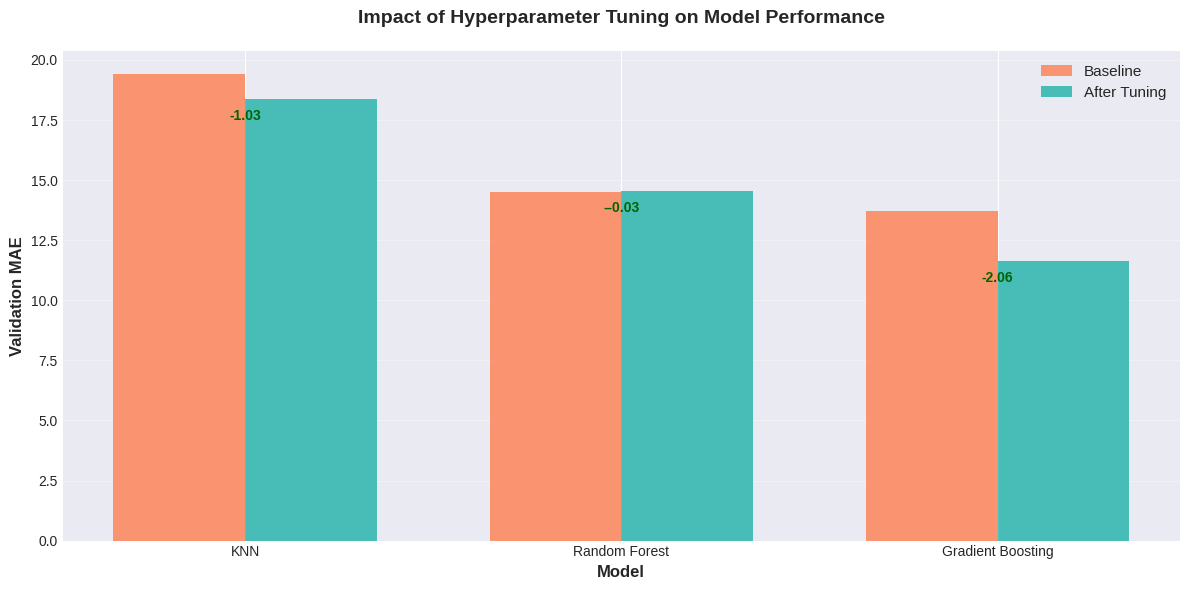

In [34]:
# Visualize tuning improvements
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(tuning_summary))
width = 0.35

bars1 = ax.bar(x - width/2, tuning_summary['Baseline_Val_MAE'], width,
               label='Baseline', alpha=0.8, color='coral')
bars2 = ax.bar(x + width/2, tuning_summary['Tuned_Val_MAE'], width,
               label='After Tuning', alpha=0.8, color='lightseagreen')

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Validation MAE', fontsize=12, fontweight='bold')
ax.set_title('Impact of Hyperparameter Tuning on Model Performance',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(tuning_summary['Model'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add improvement annotations
for i, (idx, row) in enumerate(tuning_summary.iterrows()):
    improvement = row['Improvement']
    ax.annotate(f'-{improvement:.2f}',
                xy=(i, row['Tuned_Val_MAE']),
                xytext=(0, -15),
                textcoords='offset points',
                ha='center',
                fontsize=10,
                fontweight='bold',
                color='darkgreen')

plt.tight_layout()
plt.show()

## 9. Final Model Selection and Training

### Model Selection Criteria
Based on the comprehensive evaluation and hyperparameter tuning, we select the final model for competition submission using these criteria:

1. **Validation Performance:** Lowest MAE on validation set
2. **Generalization:** Reasonable gap between training and validation scores
3. **Robustness:** Consistent performance across cross-validation folds
4. **Improvement from Tuning:** Significant benefit from hyperparameter optimization

### Final Training Strategy
Once the best model is identified, we:
- Retrain on the entire training dataset (combining train and validation splits)
- Use the optimized hyperparameters from tuning
- Maximize available training data for better generalization
- Generate predictions for the competition test set

In [35]:
# Select the best model based on tuning results
if best_overall_model == 'KNN':
    final_model = knn_best
    final_model_name = 'K-Nearest Neighbors (Tuned)'
elif best_overall_model == 'Random Forest':
    final_model = rf_best
    final_model_name = 'Random Forest (Tuned)'
else:
    final_model = gb_best
    final_model_name = 'Gradient Boosting (Tuned)'

print(f"Selected final model: {final_model_name}")
print(f"\nFinal model hyperparameters:")
print(final_model.get_params())

Selected final model: Gradient Boosting (Tuned)

Final model hyperparameters:
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.05, 'loss': 'squared_error', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 0.8, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [36]:
# Retrain on full training dataset
print(f"\nRetraining {final_model_name} on full training dataset...")
final_model.fit(X_train_final, y_train)

# Evaluate on full training set for reference
y_train_pred_final = final_model.predict(X_train_final)
final_train_mae = mean_absolute_error(y_train, y_train_pred_final)
final_train_r2 = r2_score(y_train, y_train_pred_final)

print(f"\nFinal Model Training Performance:")
print(f"Training MAE: {final_train_mae:.4f}")
print(f"Training R²: {final_train_r2:.4f}")
print("\nModel training completed successfully")


Retraining Gradient Boosting (Tuned) on full training dataset...

Final Model Training Performance:
Training MAE: 4.0568
Training R²: 0.9837

Model training completed successfully


## 10. Test Set Predictions and Submission File Generation

### Prediction Process
Using the final trained model, we generate predictions for the competition test set. The process involves:

1. **Apply Preprocessing:** Use the same transformations as training data
2. **Feature Selection:** Use only the selected features from training
3. **Generate Predictions:** Apply the trained model to test features
4. **Post-processing:** Ensure predictions are valid (non-negative integers)

### Submission Format
The competition requires a CSV file with specific format:
- Columns: city, year, weekofyear, total_cases
- Rows: One prediction for each test sample
- Values: Predicted number of dengue cases (integer)

### Validation Checks
Before submission, we verify:
- Correct number of predictions
- No missing values
- Proper data types
- Reasonable value ranges

In [37]:
# Generate predictions for test set
print("Generating predictions for test set...")
test_predictions = final_model.predict(X_test_final)

# Ensure predictions are non-negative (dengue cases cannot be negative)
test_predictions = np.maximum(test_predictions, 0)

# Round to nearest integer (case counts must be whole numbers)
test_predictions = np.round(test_predictions).astype(int)

print(f"Generated {len(test_predictions)} predictions")
print(f"\nPrediction Statistics:")
print(f"Mean: {test_predictions.mean():.2f}")
print(f"Median: {np.median(test_predictions):.2f}")
print(f"Min: {test_predictions.min()}")
print(f"Max: {test_predictions.max()}")
print(f"Std: {test_predictions.std():.2f}")

Generating predictions for test set...
Generated 416 predictions

Prediction Statistics:
Mean: 22.22
Median: 12.00
Min: 2
Max: 110
Std: 24.27


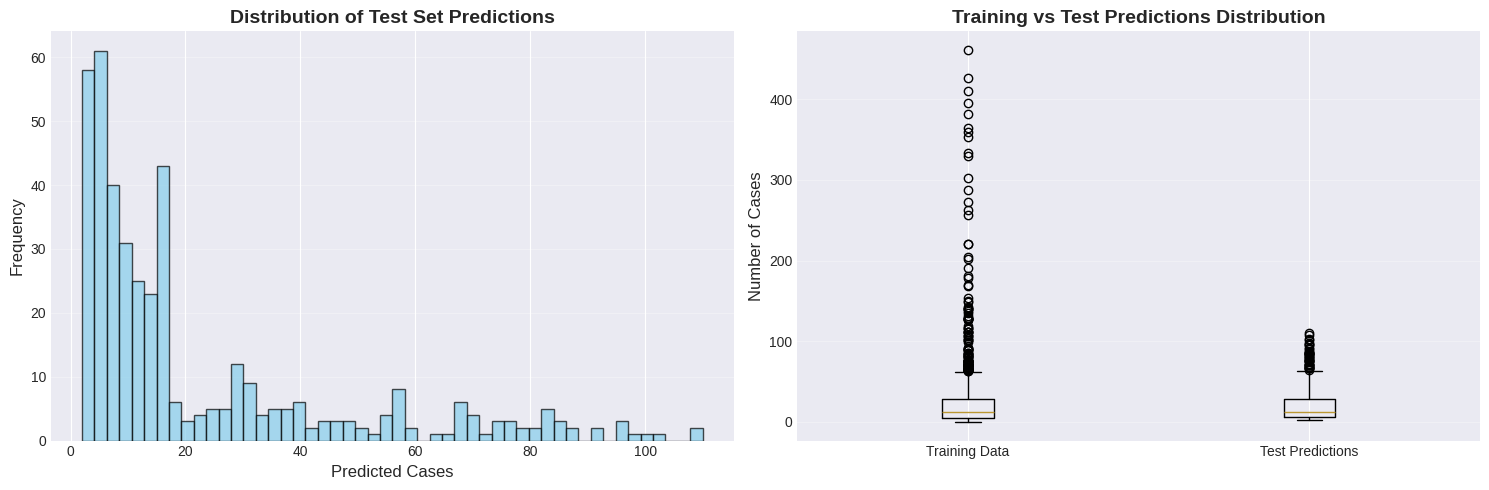

In [38]:
# Visualize prediction distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of predictions
axes[0].hist(test_predictions, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Predicted Cases', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Test Set Predictions', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot comparison with training data
axes[1].boxplot([y_train, test_predictions], labels=['Training Data', 'Test Predictions'])
axes[1].set_ylabel('Number of Cases', fontsize=12)
axes[1].set_title('Training vs Test Predictions Distribution', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# Create submission DataFrame
submission = pd.DataFrame({
    'city': test_features['city'],
    'year': test_features['year'],
    'weekofyear': test_features['weekofyear'],
    'total_cases': test_predictions
})

print("Submission DataFrame created:")
print(f"Shape: {submission.shape}")
print(f"\nFirst 10 rows:")
print(submission.head(10))

# Verify submission format
print(f"\nSubmission Verification:")
print(f"Missing values: {submission.isnull().sum().sum()}")
print(f"Negative predictions: {(submission['total_cases'] < 0).sum()}")
print(f"Data types correct: {submission['total_cases'].dtype == int}")

Submission DataFrame created:
Shape: (416, 4)

First 10 rows:
  city  year  weekofyear  total_cases
0   sj  2008          18            6
1   sj  2008          19            8
2   sj  2008          20            9
3   sj  2008          21           15
4   sj  2008          22           10
5   sj  2008          23           10
6   sj  2008          24           13
7   sj  2008          25           16
8   sj  2008          26           32
9   sj  2008          27           26

Submission Verification:
Missing values: 0
Negative predictions: 0
Data types correct: True


In [40]:
# Save submission file
submission_filename = f'dengai_submission_{final_model_name.replace(" ", "_").lower()}.csv'
submission.to_csv(submission_filename, index=False)

print(f"\nSubmission file saved: {submission_filename}")
print(f"\nFile ready for upload to DrivenData competition platform")
print(f"Expected evaluation metric: Mean Absolute Error (MAE)")


Submission file saved: dengai_submission_gradient_boosting_(tuned).csv

File ready for upload to DrivenData competition platform
Expected evaluation metric: Mean Absolute Error (MAE)
